### Objetivo

El objetivo de este notebook es explorar la data faltante, de los parquet que se hicieron al hacer la descarga masiva de la data del SIATA desde el 2018, hasta el 2020. 

Primero se realizará un cálculo del parquet del basándose en la data del s3 con lo que se encuentra en el bucket de s3. 

In [1]:
import os
import boto3
import pyart
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
dfs = {}
anos = [2018,2019,2020]
for ano in anos:
    dfs[str(ano)] = pd.read_parquet(f"{ano}_metadata.parquet")
    dfs[str(ano)]["fecha"] = pd.to_datetime(dfs[str(ano)]["fecha"]) 
dfs["2020"]["imagen"] = dfs["2020"]["imagen"]\
                            .apply(lambda x: \
                            f"{datetime.strptime(x.split('_')[0], '%Y%m%d%H%M').strftime('%Y-%m-%d-%H:%M')}_reflectivity.nc")
metadata = pd.DataFrame()
for ano in anos:
    metadata = pd.concat([metadata, dfs[str(ano)]])
metadata.reset_index(inplace=True)
metadata.drop("flag", axis = 1, inplace=True)

# Datos vacíos

Para ver qué datos están vacíos, se trara todo el contenido de la información contenida en AWS, y por medio de la metadata y el peso en bytes se mirará cuales imágenes pueden estar vacías

In [3]:
contenido = pd.read_parquet("contenido_aws.parquet")
contenido["Size"] = contenido["Size"]/1000
contenido = contenido[~contenido["Key"].str.contains("metadata")]
contenido.Key = contenido.Key.str.split("/", expand= True)[3]

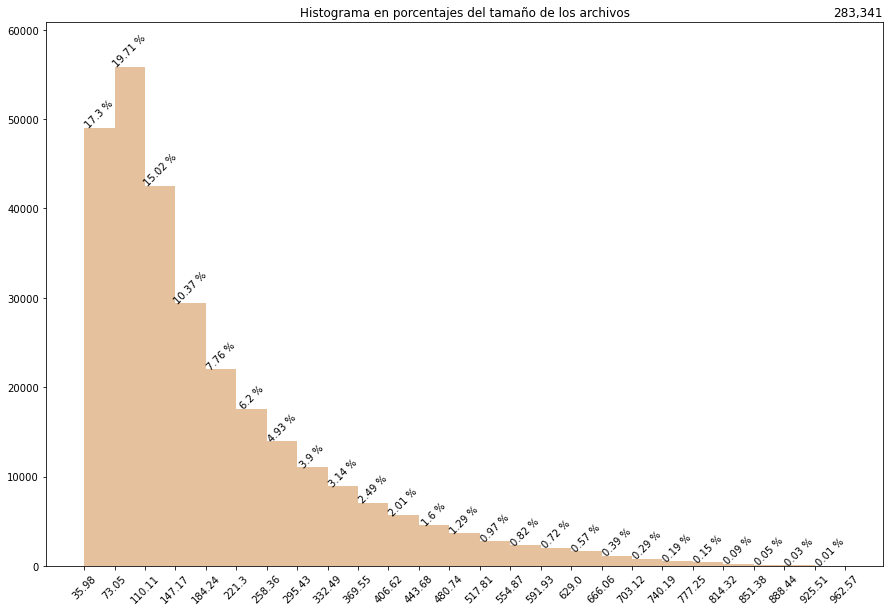

In [4]:
bins = 25
fig = plt.figure(figsize=(15,10))
histogram = plt.hist(contenido.Size, bins=bins, color = "peru", alpha = 0.5)
size_histogram = pd.cut(contenido["Size"], bins = bins, retbins=True)

# plt.yticks([])
plt.xticks(histogram[1], labels=list(map(lambda x:round(x,2),histogram[1])), rotation = 45)
for bar in histogram[2].patches:
    h = bar.get_height()
    x = bar.get_x()
    porcentaje = round((h/len(contenido))*100,2)
    width = bar.get_width()
    plt.text(x = x+width/2, y = h, s ="{:,} %".format(porcentaje), ha="center", rotation = 45)
plt.ylim([0,histogram[0].max() + 5000])
plt.title("Histograma en porcentajes del tamaño de los archivos")
plt.title("{:,}".format(len(contenido)), loc = "right")
plt.show()


In [5]:
metadata["Days"] = metadata.fecha.dt.date
metadata_dias = metadata.groupby("Days").count()
metadata_dias = metadata_dias[["imagen"]] 
metadata_dias["res_5min"] = len(pd.date_range("01/01/2023", "01/02/2023", freq = "5T")[:-1])
metadata_dias.index = pd.to_datetime(metadata_dias.index, format="%Y-%m-%d")
metadata_dias["Period"] = metadata_dias.index.to_period("M")
metadata_periodos = metadata_dias.groupby("Period").sum()
metadata_periodos["Porcentaje"] = round((metadata_periodos.imagen / metadata_periodos.res_5min)*100,2) 
metadata_periodos["año"] = metadata_periodos.index.year

conditions = [
    (metadata_periodos.año == 2018),
    (metadata_periodos.año == 2019),
    (metadata_periodos.año == 2020)
]

valores = [
    "FireBrick",
    "Peru",
    "Teal"
]

metadata_periodos["Colors"] = np.select(conditions, valores)
fig = plt.figure(figsize=(17,7))
bars = plt.bar(metadata_periodos.index.strftime("%Y-%m-%d"), metadata_periodos.Porcentaje, color = metadata_periodos.Colors, alpha = 0.7)
plt.xticks(range(len(metadata_periodos)), labels = metadata_periodos.index.strftime("%Y-%m-%d"), rotation = 45)
plt.title("Porcentaje de datos de cada mes resolución de 5 minutos")
plt.axhline(85, color = "red", linestyle = "--")
plt.ylim([70,100])


for rectangulo in bars.patches:
    h = rectangulo.get_height()
    width = rectangulo.get_width()
    x = rectangulo.get_x()
    plt.text(x, h + width/2, str(h), rotation = 45)
plt.show()

Se analizará el tamaño de nulos de cada imagen, y las imágenes que tienen porcentaje > 0 

In [6]:
metadata_cantidad = pd.DataFrame()

for ano in anos:
    metadata_cantidad = pd.concat([metadata_cantidad, pd.read_csv(f"{ano}_metadata.csv")])

metadata_cantidad.fecha = metadata_cantidad.fecha.str.split(".", expand= True)[0]
metadata_cantidad.fecha = pd.to_datetime(metadata_cantidad.fecha, format= "%Y-%m-%d %H:%M:%S")
metadata_cantidad["ano"] = metadata_cantidad.fecha.dt.year

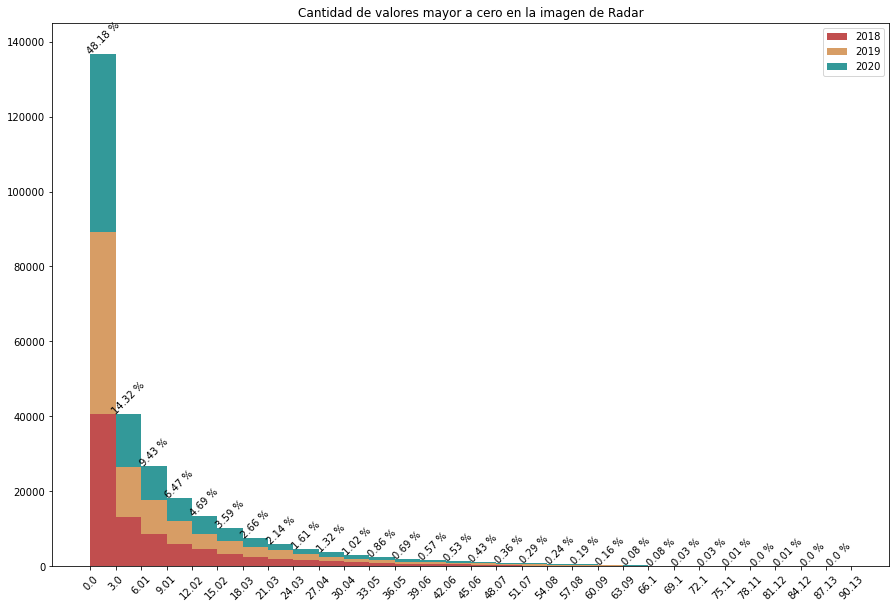

In [7]:
fig = plt.figure(figsize=(15,10))
bins = 30

hist = plt.hist(metadata_cantidad.mayor_cero,bins = bins, alpha = 0)
histograma = plt.hist([metadata_cantidad.loc[:,["mayor_cero", "ano"]][metadata_cantidad.loc[:,["mayor_cero", "ano"]]["ano"] == 2018].mayor_cero,
            metadata_cantidad.loc[:,["mayor_cero", "ano"]][metadata_cantidad.loc[:,["mayor_cero", "ano"]]["ano"] == 2019].mayor_cero,
            metadata_cantidad.loc[:,["mayor_cero", "ano"]][metadata_cantidad.loc[:,["mayor_cero", "ano"]]["ano"] == 2020].mayor_cero],
            bins = bins, stacked=True, color = ["Firebrick" ,"Peru","Teal", ], alpha = 0.8, label = [2018, 2019, 2020])
plt.xticks(histograma[1], labels=list(map(lambda x:round(x,2),histograma[1])), rotation = 45)
canitdad_ano = metadata_cantidad.groupby("ano").sum()
porcentaje_mayor_cero = pd.cut(metadata_cantidad.mayor_cero, bins = bins, retbins=True)
metadata_cantidad["intervalo"] = porcentaje_mayor_cero[0].apply(lambda x: x.right)
cantidad_ano_mayor_cero = metadata_cantidad.groupby(["intervalo", "ano"]).count()


for bar in hist[2].patches:
    h = bar.get_height()
    x = bar.get_x()
    porcentaje = round((h/len(metadata_cantidad))*100,2)
    width = bar.get_width()
    plt.text(x = x+width/2, y = h, s ="{:,} %".format(porcentaje), ha="center", rotation = 45)

plt.ylim([0,145000])
plt.title("Cantidad de valores mayor a cero en la imagen de Radar")

plt.legend()
plt.show()



In [ ]:
imagen_casi_nula = "2020-12-31-23:37_reflectivity.nc"
imagen_casi_completa = "2020-06-21-03:39_reflectivity.nc"
